# Explorative Data Analysis (EDA)

Source of dataset: https://www.kaggle.com/austinreese/craigslist-carstrucks-data

## Setup

Before you run this notebook, create a folder named Kaggle in your Google Drive and upload your Kaggle API token file (JSON) to it

In [1]:
from google.colab import drive
import os

# skip, if not running on Google Colab
drive.mount('/content/gdrive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle


In [2]:
## Only needs to be executed the first time
# !kaggle datasets download -d austinreese/craigslist-carstrucks-data

# #unzipping the zip files and deleting the zip files
# !unzip \*.zip  && rm *.zip

In [9]:
# import modules and set options
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

pd.options.display.max_rows = 500 #default = 60
sns.set_theme(style="whitegrid")

In [4]:
# load csv dataset into DataFrame
df = pd.read_csv('vehicles.csv')

In [5]:
# sneak peek on data
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [6]:
df.tail()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
426875,7301591192,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,https://images.craigslist.org/00o0o_iiraFnHg8q...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:31-0600
426876,7301591187,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,https://images.craigslist.org/00x0x_15sbgnxCIS...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:29-0600
426877,7301591147,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,https://images.craigslist.org/00L0L_farM7bxnxR...,Carvana is the safer way to buy a car During t...,NaN,wy,33.779214,-84.411811,2021-04-04T03:21:17-0600
426878,7301591140,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,https://images.craigslist.org/00z0z_bKnIVGLkDT...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:11-0600
426879,7301591129,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,NaN,coupe,NaN,https://images.craigslist.org/00Y0Y_lEUocjyRxa...,Carvana is the safer way to buy a car During t...,NaN,wy,33.779214,-84.411811,2021-04-04T03:21:07-0600


# Duplicates

First we are going to check this dataset for redundant entries

In [ ]:
# check dataset for duplicates
df.duplicated().value_counts()

False    426880
dtype: int64

...there don't seem to be any

# Missing Values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

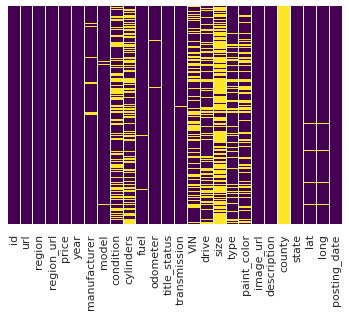

In [8]:
# show missing values (missing values - if present - will be displayed in yellow)
sns.heatmap(df.isnull(), 
            yticklabels=False,
            cbar=False, 
            cmap='viridis');

id


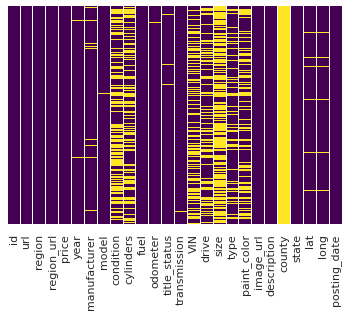

url


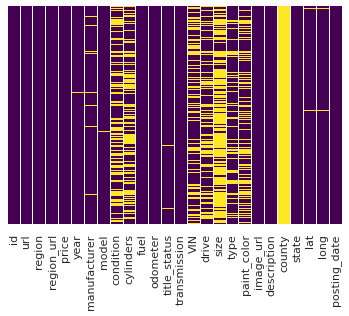

region


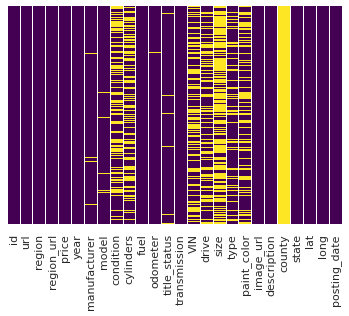

region_url


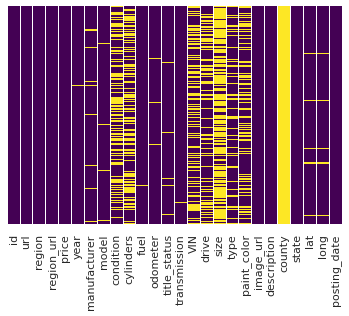

price


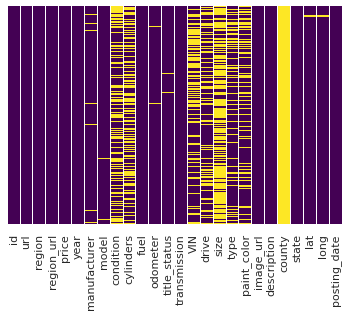

year


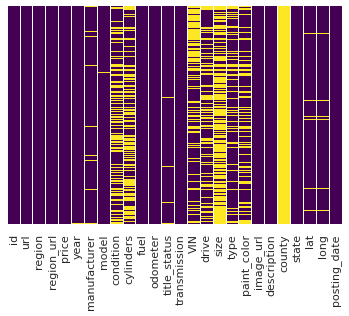

manufacturer


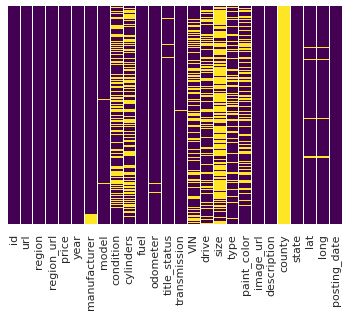

model


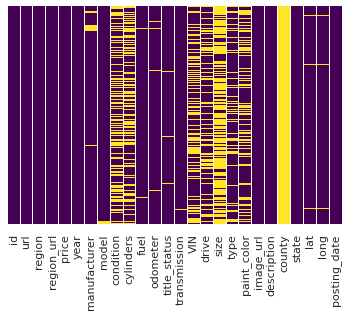

condition


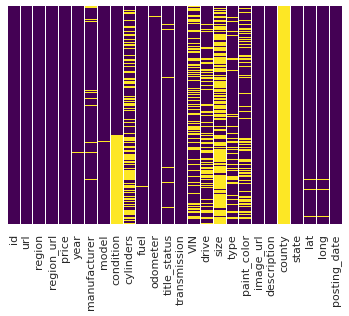

cylinders


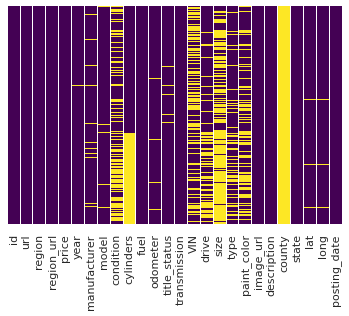

fuel


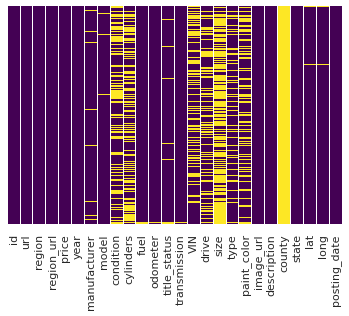

odometer


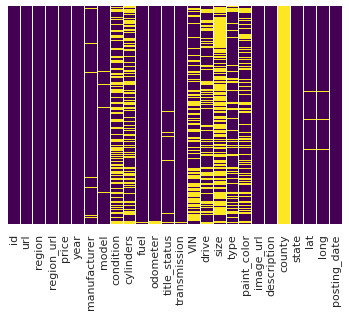

title_status


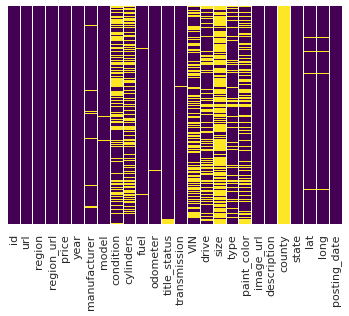

transmission


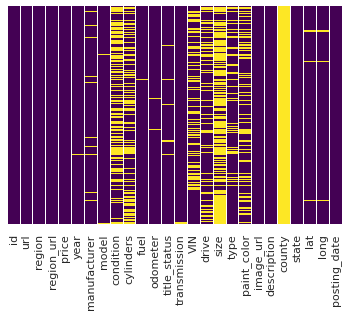

VIN


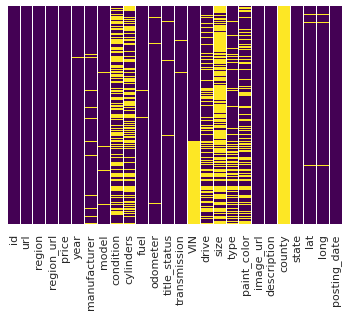

drive


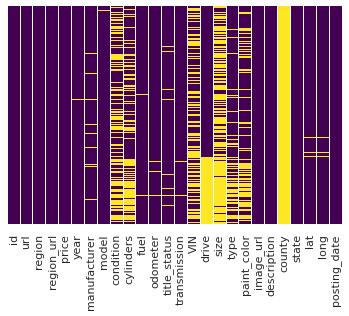

size


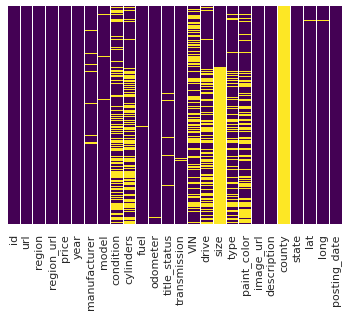

type


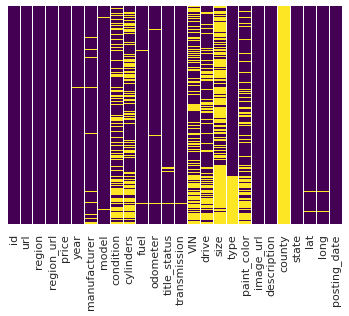

paint_color


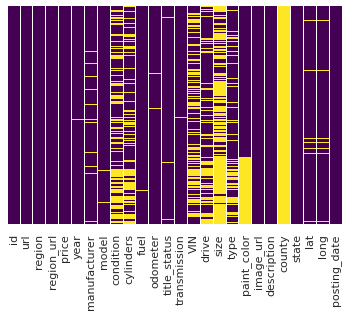

image_url


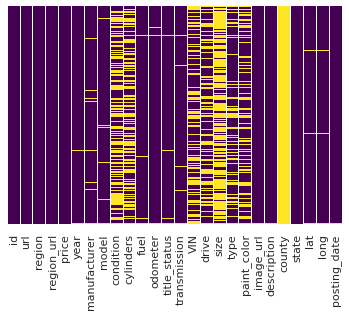

description


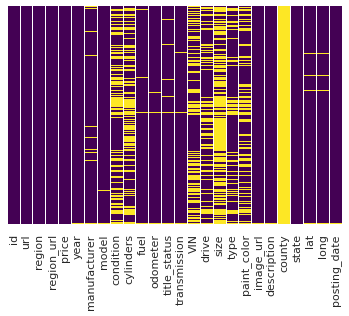

county


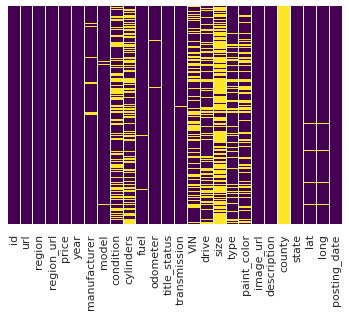

state


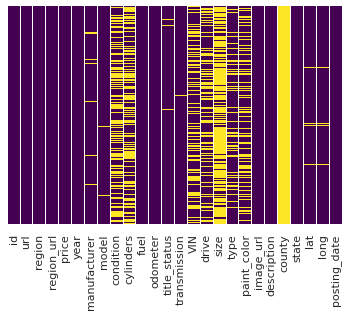

lat


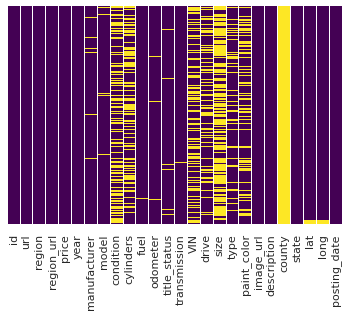

long


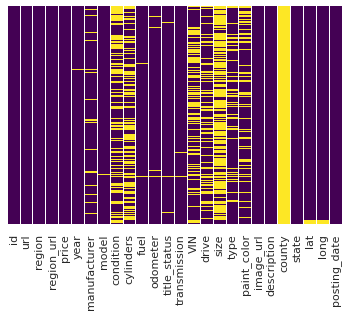

posting_date


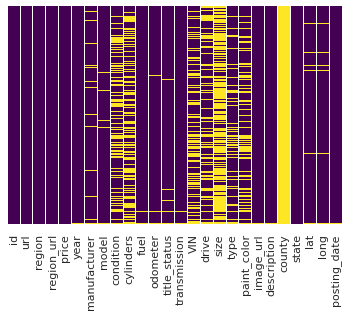

In [9]:
# show missing values - sorted by each column

for elem in df:
  print(elem)
  sns.heatmap(df.sort_values(by=[elem]).isnull(), 
              yticklabels=False,
              cbar=False, 
              cmap='viridis');
  plt.show()

Column "county" has no values in it and therefore can be discarded.

The other missing values could be a result of optional fields that car advertisers didn't fill in.
The amount of missing values play a major role in how we need to handle them. While isolated instances of missing values can be filled in with imputation techniques (assuming values are missing at random), large subsets of missing values like in "size" need to be handled differently, since a lot of interpolated data can skew this feature greatly.

When plotting missing values sorted by different features, some missing-value patterns might become apparent.
For instance when you sort the dataset by year, it is seen that there are more missing values on the "VIN" feature as the car gets older. This could be the effect of older cars not being registered to drive. This is an example for data "not missing at random".

There also seems to be a correlation between the missing values of features. For example when sorted by type, size, cylinders, condition, VIN or paint you can see that these features conglomorate at the end. These features could have been optional information boxes that haven't been filled in by advertisers.

In the data preprocessing step, we'll take an algorithmic approach in identifying whether the data has "missing completly at random" values with the Little's Test.

# Visual Data Inspection


## Overview

In [ ]:
# Stats of numerical features
df.describe(include=[np.number])

,id,price,year,odometer,county,lat,long
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05,0.0,420331.000000,420331.000000
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04,NaN,38.493940,-94.748599
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05,NaN,5.841533,18.365462
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-84.122245,-159.827728
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04,NaN,34.601900,-111.939847
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04,NaN,39.150100,-88.432600
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05,NaN,42.398900,-80.832039
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07,NaN,82.390818,173.885502


When inspecting the "price" feature, there seems to be a big outlier with a car being priced at over 3.7 billion.
It's most likely a jokingly made offer and something to be removed in the preprocessing section, as they can heavily skew our models.

In [ ]:
# allocating numerical features to num_df variable
num_df = df.select_dtypes(include=[np.number])
num_df

,id,price,year,odometer,county,lat,long
0,7222695916,6000,NaN,NaN,NaN,NaN,NaN
1,7218891961,11900,NaN,NaN,NaN,NaN,NaN
2,7221797935,21000,NaN,NaN,NaN,NaN,NaN
3,7222270760,1500,NaN,NaN,NaN,NaN,NaN
4,7210384030,4900,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
426875,7301591192,23590,2019.0,32226.0,NaN,33.786500,-84.445400
426876,7301591187,30590,2020.0,12029.0,NaN,33.786500,-84.445400
426877,7301591147,34990,2020.0,4174.0,NaN,33.779214,-84.411811
426878,7301591140,28990,2018.0,30112.0,NaN,33.786500,-84.445400


In [ ]:
# Stats of categorical features
df.describe(include=['object'])

,url,region,region_url,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,posting_date
count,426880,426880,426880,409234,421603,252776,249202,423867,418638,424324,265838,296313,120519,334022,296677,426812,426810,426880,426812
unique,426880,404,413,42,29667,6,8,5,6,3,118264,3,4,13,12,241899,360911,51,381536
top,https://sandiego.craigslist.org/esd/ctd/d/gard...,columbus,https://spokane.craigslist.org,ford,f-150,good,6 cylinders,gas,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,https://images.craigslist.org/00N0N_1xMPvfxRAI...,35 VEHICLES PRICED UNDER $3000!!! BIG TIME! T...,ca,2021-04-23T22:13:05-0400
freq,1,3608,2988,70985,8009,121456,94169,356209,405117,336524,261,131904,63465,87056,79285,7357,231,50614,12


This overview not only gives us a compilation of the most prominent car configurations, but also gives us a glimps of potential spam sumbissions, when looking at the "description" column.

In [ ]:
# allocating categorical variables to cat_df variable
cat_df = df.select_dtypes(include=['object'])
cat_df

,url,region,region_url,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,posting_date
0,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN
1,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN
2,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN
3,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN
4,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,nissan,maxima s sedan 4d,good,6 cylinders,gas,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,https://images.craigslist.org/00o0o_iiraFnHg8q...,Carvana is the safer way to buy a car During t...,wy,2021-04-04T03:21:31-0600
426876,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,https://images.craigslist.org/00x0x_15sbgnxCIS...,Carvana is the safer way to buy a car During t...,wy,2021-04-04T03:21:29-0600
426877,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,cadillac,xt4 sport suv 4d,good,NaN,diesel,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,https://images.craigslist.org/00L0L_farM7bxnxR...,Carvana is the safer way to buy a car During t...,wy,2021-04-04T03:21:17-0600
426878,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,lexus,es 350 sedan 4d,good,6 cylinders,gas,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,https://images.craigslist.org/00z0z_bKnIVGLkDT...,Carvana is the safer way to buy a car During t...,wy,2021-04-04T03:21:11-0600


Next, let's look at some of these features in greater detail...

## Categorical data:

### Region

In [ ]:
# Region stats
df[['region']].value_counts(normalize=False)

region                 
columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Length: 404, dtype: int64

### Manufacturer

In [ ]:
# manufacturer stats
df[['manufacturer']].value_counts(normalize=False)

manufacturer   
ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda               5427
infiniti            4802
lincoln             4220
volvo               3374
mitsubishi          3292
mini                2376
pontiac             2288
rover               2113
jaguar              1946
porsche             1384
mercury             1184
saturn              1090
alfa-romeo           897
tesla                868
fiat                 792
harley-davidson      153
ferrari               95
datsun                63
aston-mar

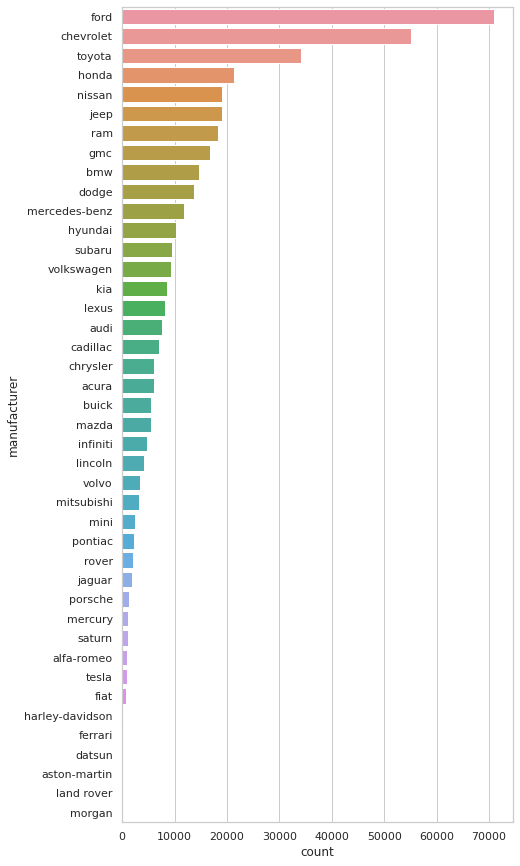

In [ ]:
df[['manufacturer']].value_counts(normalize=False)
f, ax = plt.subplots(figsize=(7, 15))
sns.countplot(data=df, y='manufacturer', order=df['manufacturer'].value_counts(normalize=False).index)

### Model

In [10]:
df['model'].value_counts()

f-150             8009
silverado 1500    5140
1500              4211
camry             3135
silverado         3023
                  ... 
1952                 1
x1 328i              1
500 sel              1
cruse                1
prius hybrid v       1
Name: model, Length: 29667, dtype: int64

There is a total of 29667 car models in this dataset, meaning that every 13th user has a unique model name in his advert, reason probably being that advertisers can enter their own string as model name which results many written variations of the same model. With rigorous preprocessing we could cleanse the data by assigning a string to one model. This could be done via fuzzy matching, but this would go beyond the scope of this project
We'll take a closer look at the most common car models and see if they sum up to be a significant subset of all entries.

In [40]:
model_df = pd.DataFrame(df['model'].value_counts().rename_axis('model').reset_index(name='count'))
model_df = model_df.loc[model_df['count'] >= 100] # select all models that appear more than 99 times --> implying that these are actually models
print("models:\t\t{}".format(len(model_df)))
print("submissions:\t{}".format(model_df['count'].sum()))

models:		658
submissions:	263528


658 models in this dataset appear 100x and more in this dataset, which in sum covers for 263528 entries in this dataset.
By removing 'outlier' car models we would retain over 250k entries in out dataset.
Since these are categorical values the question remains whether these features are to any use for our usecase.

One-Hot encoding 600+ models would lead to a very sparse matrix, which could have impact severe impact on our models, as well as giving the 'model' feature an overproportional amount of weight in comparison to other features. (A total 658 dimensions are solely allocated for the car model)

### Condition

In [ ]:
# condition stats
df[['condition']].value_counts(normalize=False)

condition
good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
dtype: int64

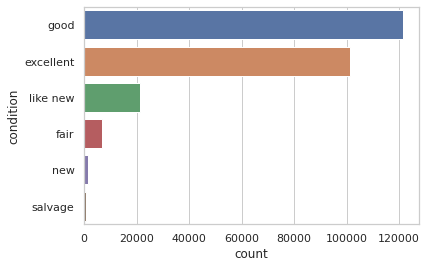

In [ ]:
sns.countplot(data=df, y='condition', order=df['condition'].value_counts(normalize=False).index)

### Cylinders

In [ ]:
# cylinders stats
df[['cylinders']].value_counts(normalize=False)

cylinders   
6 cylinders     94169
4 cylinders     77642
8 cylinders     72062
5 cylinders      1712
10 cylinders     1455
other            1298
3 cylinders       655
12 cylinders      209
dtype: int64

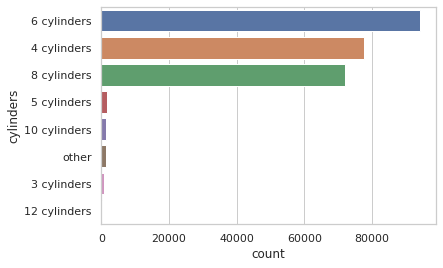

In [ ]:
sns.countplot(data=df, y='cylinders', order=df['cylinders'].value_counts(normalize=False).index)

### Fuel

In [ ]:
# fuel stats
df[['fuel']].value_counts(normalize=False)

fuel    
gas         356209
other        30728
diesel       30062
hybrid        5170
electric      1698
dtype: int64

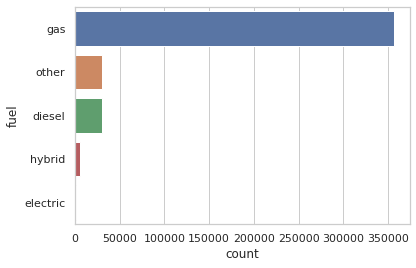

In [ ]:
sns.countplot(data=df, y='fuel', order=df['fuel'].value_counts(normalize=False).index)

### Title Status

In [ ]:
# title_status stats
df[['title_status']].value_counts(normalize=False)

title_status
clean           405117
rebuilt           7219
salvage           3868
lien              1422
missing            814
parts only         198
dtype: int64

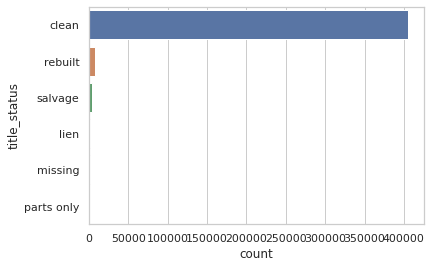

In [ ]:
sns.countplot(data=df, y='title_status', order=df['title_status'].value_counts(normalize=False).index)

### Transmission

In [ ]:
# transmission stats
df[['transmission']].value_counts(normalize=False)

transmission
automatic       336524
other            62682
manual           25118
dtype: int64

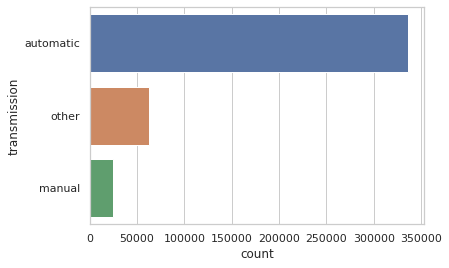

In [ ]:
sns.countplot(data=df, y='transmission', order=df['transmission'].value_counts(normalize=False).index)

### Drive

In [ ]:
# drive stats
df[['drive']].value_counts(normalize=False)

drive
4wd      131904
fwd      105517
rwd       58892
dtype: int64

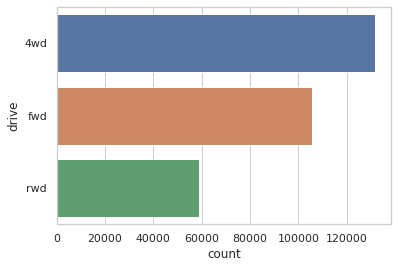

In [ ]:
sns.countplot(data=df, y='drive', order=df['drive'].value_counts(normalize=False).index)

### Size

In [ ]:
# size stats
df[['size']].value_counts(normalize=False)

size       
full-size      63465
mid-size       34476
compact        19384
sub-compact     3194
dtype: int64

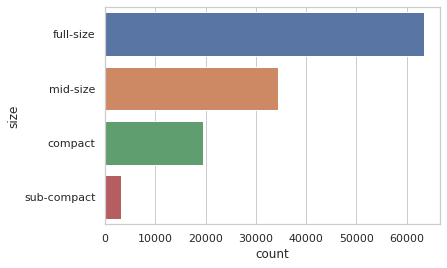

In [ ]:
sns.countplot(data=df, y='size', order=df['size'].value_counts(normalize=False).index)

### Type

In [ ]:
# type stats
df[['type']].value_counts(normalize=False)

type       
sedan          87056
SUV            77284
pickup         43510
truck          35279
other          22110
coupe          19204
hatchback      16598
wagon          10751
van             8548
convertible     7731
mini-van        4825
offroad          609
bus              517
dtype: int64

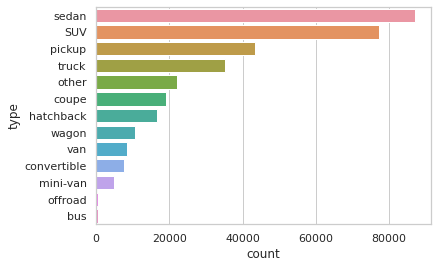

In [ ]:
sns.countplot(data=df, y='type', order=df['type'].value_counts(normalize=False).index)

### Paint Color

In [ ]:
# paint_color stats
df[['paint_color']].value_counts(normalize=False)

paint_color
white          79285
black          62861
silver         42970
blue           31223
red            30473
grey           24416
green           7343
custom          6700
brown           6593
yellow          2142
orange          1984
purple           687
dtype: int64

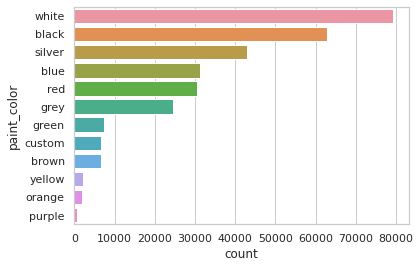

In [ ]:
sns.countplot(data=df, y='paint_color', order=df['paint_color'].value_counts(normalize=False).index)

### State

In [ ]:
# state stats
df[['state']].value_counts(normalize=False)

state
ca       50614
fl       28511
tx       22945
ny       19386
oh       17696
or       17104
mi       16900
nc       15277
wa       13861
pa       13753
wi       11398
co       11088
tn       11066
va       10732
il       10387
nj        9742
id        8961
az        8679
ia        8632
ma        8174
mn        7716
ga        7003
ok        6792
sc        6327
mt        6294
ks        6209
in        5704
ct        5188
al        4955
md        4778
nm        4425
mo        4293
ky        4149
ar        4038
ak        3474
la        3196
nv        3194
nh        2981
dc        2970
me        2966
hi        2964
vt        2513
ri        2320
sd        1302
ut        1150
wv        1052
ne        1036
ms        1016
de         949
wy         610
nd         410
dtype: int64

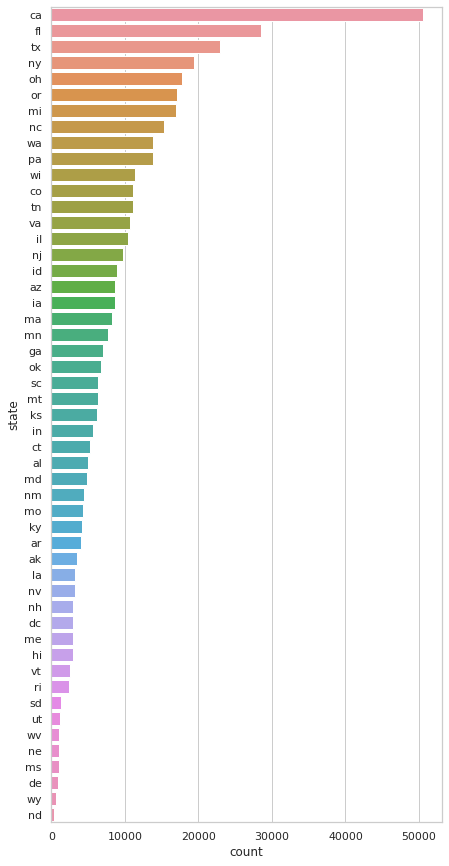

In [ ]:
f, ax = plt.subplots(figsize=(7, 15))
sns.countplot(data=df, y='state', order=df['state'].value_counts(normalize=False).index)

We won't bother to plot out the remaining features, as they have too many unique values to make a sensible plot out of.
Especially featuers like 'VIN' and 'url' as they serve as unique identifier and don't serve a lot of value in this analysis

## Numerical data:

### Year

In [ ]:
# year stats
df[['year']].value_counts(normalize=False)

year  
2017.0    36420
2018.0    36369
2015.0    31538
2013.0    30794
2016.0    30434
          ...  
1902.0        1
1915.0        1
1905.0        1
1909.0        1
1918.0        1
Length: 114, dtype: int64

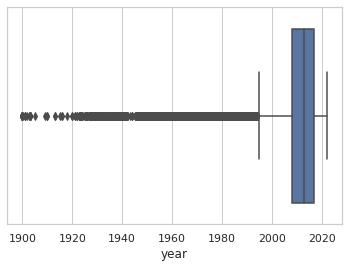

In [ ]:
ax = sns.boxplot(x=df["year"])

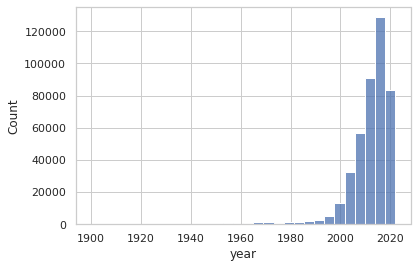

In [ ]:
ax = sns.histplot(data=df["year"], bins=30)

As we can see, for feature **'year'** there is a negative skew as the offers on older cars become increasingly rarer

### Price

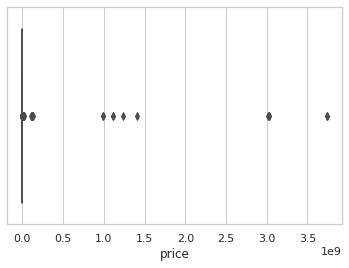

In [ ]:
ax = sns.boxplot(x=df["price"])

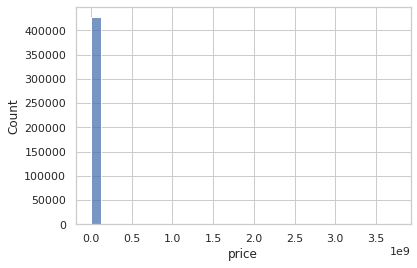

In [ ]:
ax = sns.histplot(data=df["price"], bins=30)

The **'price'** feature is highly positively skewed by very few offers, probably by aforementioned troll submissions.
These outliers need to be taken care of in the preprocessing step.

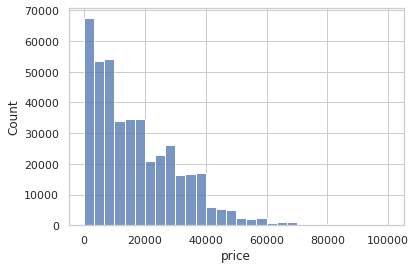

In [ ]:
ax = sns.histplot(data=df["price"].loc[df['price'] < 100000], bins=30)

Even after removing some outliers, the data is still very heavily skewed to the left and resembles a typical logarithmic distribution

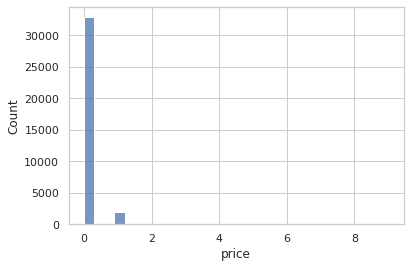

In [ ]:
ax = sns.histplot(data=df["price"].loc[df['price'] < 10], bins=30)

30000 adverts have a price tag of zero.
This needs to be further investigated and evaluated, whether to remove them. First it needs to be established if there is a correlation between the price of zero and the condition of a car, as totalled cars often get offered for free in order to circumvent paying scrapyard fees. 

### Odometer

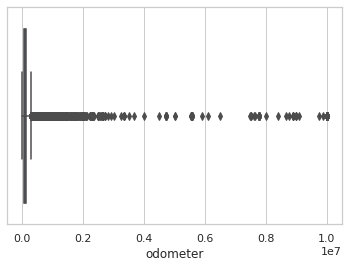

In [ ]:
ax = sns.boxplot(x=df["odometer"])

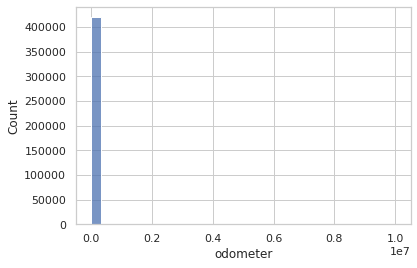

In [ ]:
ax = sns.histplot(data=df["odometer"], bins=30)

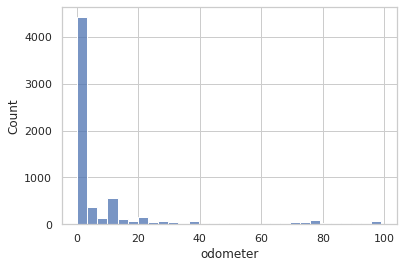

In [ ]:
ax = sns.histplot(data=df["odometer"].loc[df['odometer'] < 100], bins=30)

Skews in distribution need to be taken into account when modelling as non-normal distributed data can have significant impact on model quality

## Date

In [ ]:
# posting_date
posting_date = df['posting_date'] #not a copy, but a slice of out dataframe

Posting dates are still of type string, which serve limited value for our analysis. First we need to convert these entries into a datetime value, before proceeding with our analysis.

Let's convert all strings to the appropriate datetime format:

In [ ]:
for i, elem in enumerate(posting_date):
    if type(elem) != float: # if not NaN
        datetime_elem = datetime.strptime(elem, '%Y-%m-%dT%H:%M:%S%z') #datetime format
        posting_date.iloc[i] = datetime_elem

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


KeyboardInterrupt: ignored

This takes a siginificant amount of time to process.

Having converted our dates, we now can extract specific datetime elements and work with them

<AxesSubplot:xlabel='posting_date', ylabel='Count'>

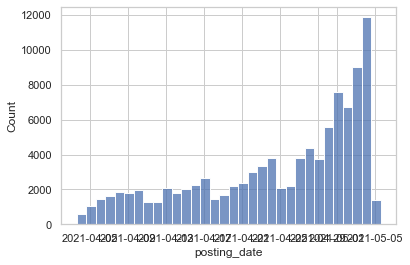

In [ ]:
sns.histplot(x=df["posting_date"])

In [ ]:
print(min(df['posting_date'].dropna()))
print(max(df['posting_date'].dropna()))

2021-04-04 01:10:23-06:00
2021-05-04 17:22:17-04:00


It is seen in the histogram that there is a higher amount of recent offers

When displaying the min and max value it can be seen that this dataset has a submission time-window of one month

In [ ]:
# show missing values (missing values - if present - will be displayed in yellow)
sns.heatmap(df.isnull(), 
            yticklabels=False,
            cbar=False, 
            cmap='viridis');

In [ ]:
# removing NaN values
df = df.dropna()
df.shape

(34785, 21)

# Distribution of Data and its Skewness

As is seen over 90% of the data has been removed, but for this data exploration task we'll prioritize data cleanliness over data quantity.

By doing correlation matrices, we can figure out features that aren't needed for some analytical tasks like linear regression

# Correlation between Features

To make out correlation between features we first need to convert categorical features into numerical ones.
One way to do this is by one-hot encoding all categorical values

In [ ]:
num_cor_df = num_df.copy() 